In [1]:
import os 
import json 
import pandas as pd
import numpy as np

In [2]:
#Fall 2024 run
# #where to save jsons
# # root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20240911_seaad\MET_typing\config'
# root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20240911_seaad\MET_typing\config_tree_top_four'

# os.makedirs(root, exist_ok=True)

# #path to ephys_file
# ephys_file = r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20240924_ng\sparse_pca_components_exc_hMET_Sep2024_flex.csv"

# #path to morph_file
# morph_file = r"\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite\RawFeatureWide_imputed.csv"

# #path to metadata (for tx labels)
# meta_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite\metadata.csv'
# ttype_mapping_alg = 'tree' #hann, corr, tree

# #membership data
# memb_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\transcriptomics\20241016\memb.csv'
# internal_node_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\transcriptomics\20241016\internal_nodes.csv'
# sample_to_cell = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\transcriptomics\20241016\id_translation_patchseq.csv' #file for translating sample ids to cell ids


In [3]:
#20251008 run 
#where to save jsons
root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250815_seaad\MET_typing\config_v1'
os.makedirs(root, exist_ok=True)

# m,e,t data files (made in 0_make_input_files.ipynb)
data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250815_seaad\MET_typing\data'
ephys_file = os.path.join(data_root, 'e_data.csv')
morph_file = os.path.join(data_root, 'm_data.csv')
tx_file = os.path.join(data_root, 't_data.feather')
meta_file = os.path.join(data_root, 'metadata.csv') #for tx labels

#HANN mapping
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

#membership data
tx_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\transcriptomics\20251003'
memb_file = os.path.join(tx_root, 'memb_new.csv')
internal_node_file = os.path.join(tx_root, 'internal_nodes.csv')
sample_to_cell = os.path.join(tx_root, 'id_translation_patchseq.csv') #file for translating sample ids to cell ids


ME clustering

In [4]:
me_clustering_dict = {
    "ephys_file": ephys_file,
    "morph_file": morph_file,
    "weights": [0.667, 1.0, 1.5], #default vals from NG - how to weight ephys and morph features. 
    "n_cl": [10, 15, 20, 25], #default vals from NG - number of clusters to form. 
    "min_consensus_n": 3, #default vals from NG - min cells in a cluster?
    "specimen_id_file": os.path.join(root, "specimen_ids.txt"),
    "cluster_labels_file":  os.path.join(root, "cluster_labels.csv"),
    "cocluster_matrix_file":  os.path.join(root, "coclustering_matrix.txt"),
    "ordering_file":  os.path.join(root, "ordering.txt"),
    "jaccards_file":  os.path.join(root, "jaccards.txt")
}

#save as json 
json_filename = os.path.join(root, 'me_clustering.json')
with open(json_filename, 'w') as json_file:
    json.dump(me_clustering_dict, json_file, indent=4)



ME clustering refined

In [5]:
me_clustering_refined_dict = {
    "cocluster_matrix_file": os.path.join(root, "coclustering_matrix.txt"),
    "jaccards_file": os.path.join(root, "jaccards.txt"),
    "cluster_labels_file": os.path.join(root, "cluster_labels.csv"),
    "refined_labels_file": os.path.join(root, "refined_labels.csv"),
    "refined_text_labels_file": os.path.join(root, "refined_text_labels.csv"),
    "refined_ordering_file": os.path.join(root, "refined_ordering.txt"),
    "me_prefix": "exc_hMET_ME",
    "coclust_threshold": 1.0 #default vals from NG - makes the refining not do anything to clusters, just reformat labels for the next step. 
  }

#save as json 
json_filename = os.path.join(root, 'me_clustering_refine.json')
with open(json_filename, 'w') as json_file:
    json.dump(me_clustering_refined_dict, json_file, indent=4)

RFC ME alternative calls

In [6]:
rfc_me_alt_calls_dict = {
    "n_iter": 100, #default vals from NG
    "n_folds": 10, #default vals from NG
    "ephys_data_file": ephys_file,
    "morph_data_file": morph_file,
    "cluster_labels_file": os.path.join(root, "refined_labels.csv"),
    "assignments_file": os.path.join(root, "rf_subsample_me_assignments.csv")
}

#save as json 
json_filename = os.path.join(root, 'alt_me_assignments.json')
with open(json_filename, 'w') as json_file:
    json.dump(rfc_me_alt_calls_dict, json_file, indent=4)

Format Tx label file

In [7]:
class_col = 'class_label_Hierarchical'
subclass_col = 'subclass_label_Hierarchical'
cluster_col = 'cluster_label_Hierarchical'

meta_df = pd.read_csv(meta_file)
tx_label_df = meta_df.rename(columns={'spec_id_label' : 'cell_id', 
                                      cluster_col : 'cluster_label',
                                      subclass_col : 'subclass_label'})[['cell_id', 'cluster_label', 'subclass_label']]

#add cluster id 
subclass_order = ['L2/3 IT', 'L4 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6b', 'L6 IT', 'L6 IT Car3']
subclass_index = {subclass: index for index, subclass in enumerate(subclass_order)}
def sort_key(s):
    subclass_name, ttype_num = s.rsplit('_',1)
    subclass_order = subclass_index.get(subclass_name, float('inf'))
    ttype_order = int(ttype_num)
    return (subclass_order, ttype_order)
ttype_order = sorted(tx_label_df.cluster_label.unique(), key=sort_key)
cluster_ids =  [i for i in range(len(ttype_order))]
cluster_id_dict = dict(zip(ttype_order, cluster_ids))
tx_label_df['cluster_id'] = tx_label_df['cluster_label'].map(cluster_id_dict)

#save
tx_label_df.to_csv(os.path.join(root, "tx_anno_file.csv"), index=False)

Format Tx alternative mapping data

In [8]:
membership_df = pd.read_csv(memb_file)
internal_node_df = pd.read_csv(internal_node_file, header=None)
sample_to_cell_df = pd.read_csv(sample_to_cell)

#get cell_id
formatted_membership_df = membership_df.merge(sample_to_cell_df, how='inner', on='sample_id')
#remove internal nodes 
internal_nodes = internal_node_df[0].tolist()
id_columns = ['sample_id', 'cell_id']
non_internal_nodes = [c for c in formatted_membership_df.columns if not c in internal_nodes and not c in id_columns]
formatted_membership_df = formatted_membership_df[['cell_id'] + non_internal_nodes]

formatted_membership_df.to_csv(os.path.join(root, "tx_mapping_file.csv"), index=False)

MET types defined

In [9]:
met_types_dict = {
    "tx_anno_file": os.path.join(root, "tx_anno_file.csv"),
    "cluster_labels_file": os.path.join(root, "refined_labels.csv"),
    "subsample_assignments_file": os.path.join(root, "rf_subsample_me_assignments.csv"),
    "tx_mapping_file": os.path.join(root, "tx_mapping_file.csv"),
    "met_node_partition_file": os.path.join(root, "met_node_partitions.json"),
    "met_assignment_file": os.path.join(root, "met_cell_assignments.csv"),
    "me_map_pt_file": os.path.join(root, "me_map_pt.csv"),
    "t_map_pt_file": os.path.join(root, "t_map_pt.csv")
}

#save as json 
json_filename = os.path.join(root, 'met_types.json')
with open(json_filename, 'w') as json_file:
    json.dump(met_types_dict, json_file, indent=4)

Spectral co-clustering for me x t plot

In [12]:
spectral_coclustering_dict = {
    "tx_anno_file" : os.path.join(root, "tx_anno_file.csv"),
    "me_cluster_labels_file" : os.path.join(root, "refined_labels.csv"),
    "output_file" : os.path.join(root, "spectral_coclust_results.json"),
    "min_n_ttype" : 1 #default vals from NG
}

#save as json 
json_filename = os.path.join(root, 'spectral_coclustering.json')
with open(json_filename, 'w') as json_file:
    json.dump(spectral_coclustering_dict, json_file, indent=4)

Format tx color file (csv --> tsv)

In [13]:
#get seaad colors 
seaad_colors_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\seaad_colors\SEAAD_colors.xlsx'
seaad_colors = pd.read_excel(seaad_colors_path, sheet_name='in')
seaad_colors = seaad_colors.rename(columns={'Unnamed: 0':'label'})
color_dict = dict(zip(seaad_colors['label'], seaad_colors['supertype_scANVI_leiden_colors']))
color_dict['TBD'] = '#808080' #cells withough seaad mapping plot grey 

# Convert the dictionary to a DataFrame
color_df = pd.DataFrame(list(color_dict.items()), columns=['cluster_label', 'cluster_color'])

# Save the DataFrame to a TSV file
color_df.to_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\seaad_colors\SEAAD_colors.tsv', sep='\t', index=False)


MET matrix graph fig

In [14]:
def window_to_unix_path(path):
    return path[1:].replace('\\', '/')

In [15]:
met_matrix_graph_fig_dict = {
    "tx_anno_file" : os.path.join(root, "tx_anno_file.csv"),
    "tx_color_file" : r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\seaad_colors\SEAAD_colors.tsv',
    "me_cluster_labels_file" : os.path.join(root, "refined_labels.csv"),
    "spec_results_file" : os.path.join(root, "spectral_coclust_results.json"),
    "met_partition_file" : os.path.join(root, "met_node_partitions.json"),
    "me_map_pt_file": os.path.join(root, "me_map_pt.csv"),
    "t_map_pt_file": os.path.join(root, "t_map_pt.csv"),
    "met_cell_assignments_file" : os.path.join(root, "met_cell_assignments.csv"),
    "output_file" : os.path.join(root, "fig_met_matrix_graph.pdf")
}

# convert to unix path 
for key in met_matrix_graph_fig_dict:
    met_matrix_graph_fig_dict[key] = window_to_unix_path(met_matrix_graph_fig_dict[key])

#save as json 
json_filename = os.path.join(root, 'met_matrix_graph_fig.json')
with open(json_filename, 'w') as json_file:
    json.dump(met_matrix_graph_fig_dict, json_file, indent=4)

In [16]:
print(window_to_unix_path(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20240911_seaad\MET_typing\config\met_matrix_graph_fig.json'))

/allen/programs/celltypes/workgroups/mousecelltypes/SarahWB/datasets/human_exc/analysis/20240911_seaad/MET_typing/config/met_matrix_graph_fig.json


Random testing delete... 

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
formatted_membership_df = pd.read_csv(os.path.join(root, "tx_mapping_file.csv"))

In [ ]:
#get me cells 
ephys_df = pd.read_csv(ephys_file, index_col=0)
morph_df = pd.read_csv(morph_file, index_col='specimen_id')
# me_cells = list(set(ephys_df.index).intersection(set(morph_df.index)))

#get cell order 
row_order = tx_label_df.merge(meta_df, how='inner', left_on='cell_id', right_on='spec_id_label').sort_values(['cluster_id'], ascending=[True])['cell_id']
# row_order = [x for x in row_order if x in me_cells]

#get tx order 
col_order = tx_label_df[['cluster_label', 'cluster_id']].drop_duplicates().sort_values('cluster_id').cluster_label.tolist()

#get tx alt mapping just for excitatory labels for me cells
membership = formatted_membership_df.set_index('cell_id') #.loc[me_cells]
exc_types = [x for x in membership.columns if x.startswith('L') and not x.startswith('Lamp')]
membership = membership[exc_types]


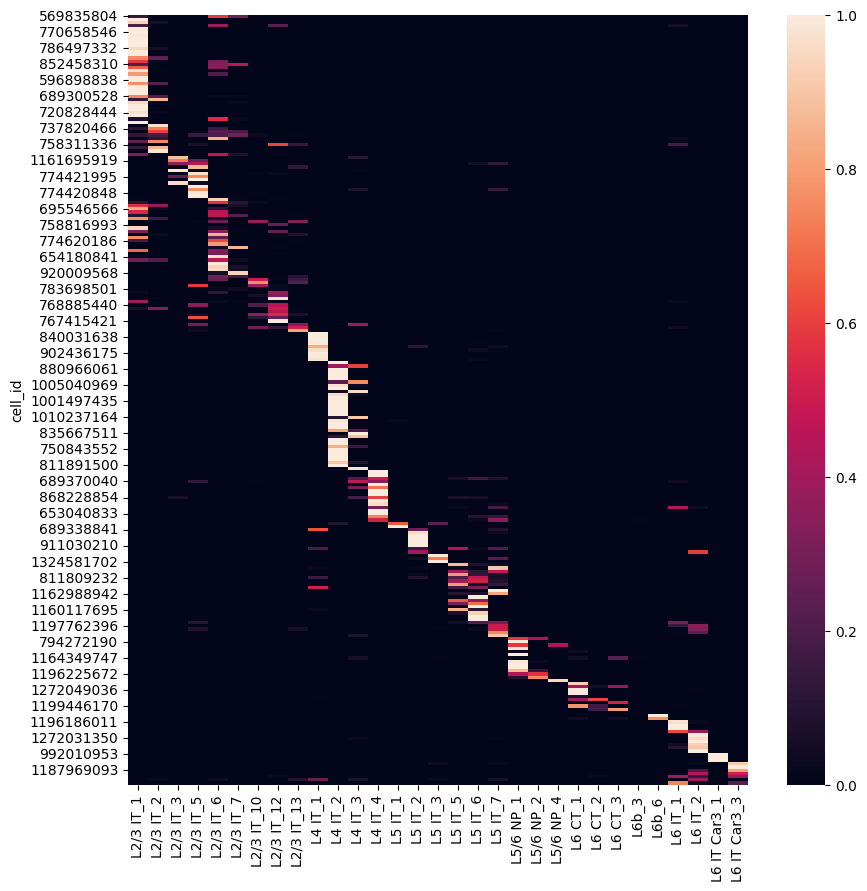

In [ ]:
clustered_data = membership.loc[row_order, col_order]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(clustered_data, square=False)
plt.show()